There is a general agreement that if you decide to use a too complicated model for a simple data set, then you'll introduce a lot of variance, which tends to overfit your data, terrible situation, all your predictions would be off. But also if you use too simple of a model for a complicated data set, then it is not going to be able to fit it no matter how many samples you have, it introduces bias. Again, very terrible. 

One might think if I have enough data points, the more complicated model should learn the extra parameters should be chosen as zero, but does it? We will see below that not always, but there are ways to mitigate this. For example we could sample, find params, average them, and then change the non-stat-sig ones to zero!

This is a very simplistic approach and might not work for all use cases.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_linear_1d(n, params):
    params = np.array(params).reshape([1,-1])
    x = np.linspace(0,1,n).reshape([-1,1])
    xc = np.c_[np.ones_like(x), x].transpose()
    y = np.dot(params, xc).reshape([-1,1])
    noise = rs.uniform(low=-1.0, high=1.0, size=n)
    yn = y + noise.reshape([-1,1])
    return [x, y, yn, params]


def plot_data(x, y):
    plt.scatter(x, yn, s = 1)


def plot_curve(x, y, params):
    label = ['{:0.3f} x^{}'.format(c, i) for i, c in enumerate(params[0])]
    label = 'y = ' + ' + '.join(label)
    plt.plot(x, y, 'r-', label = label)
    

def fit(x, yn, deg = 2):
    params = np.polyfit(
        np.squeeze(x), 
        yn, 
        deg = deg, 
        rcond=None, 
        full=False, 
        w=None, 
        cov=False
    ).transpose()
    return params[:,::-1]


def augment_x(x, l):
    xcc = np.c_[np.ones_like(x), x]
    if l > 2:
        for i in range(2, l):
            xcc = np.c_[xcc, x**i]
    xcc = xcc.transpose()
    return xcc


def pred(x, params):
    xcc = augment_x(x, l = params.shape[1])
    yh = np.dot(params, xcc).reshape([-1,1])
    return yh


def rmse(yh, y):
    r = np.sqrt(np.mean((yh - y)**2))
    return r


def pred_conf(x, all_params, alpha = .05):
    xcc = augment_x(x, l = all_params.shape[1])
    all_yh = np.dot(all_params, xcc)
    yhu = np.percentile(a = all_yh, q = 100 * (1 - alpha / 2), axis = 0)
    yhl = np.percentile(a = all_yh, q = 100 * (alpha / 2), axis = 0)
    return [yhl,yhu]


def plot_pred_conf(x, yn, yh, params_mean, yhl, yhu):
    plot_data(x, yn)
    plot_curve(x, yh, params_mean)
    plt.fill_between(np.squeeze(x),yhl, yhu, alpha = .2, color = 'r')
    plt.legend()
    plt.show()

    
def plot_all_params(all_params):
    plt.figure(figsize = [15,5])
    for i in range(all_params.shape[1]):
        ma = np.cumsum(all_params[:,i]) / np.arange(1, len(all_params) + 1)
        mu = np.mean(all_params[:,i])
        sigma = np.std(all_params[:,i])
        
        plt.subplot(1,all_params.shape[1], i+1)
        plt.scatter(np.arange(len(all_params)), all_params[:,i], s = 1)
        plt.plot(ma, 'r-', label = '{:0.3f}'.format(ma[-1]))
        plt.axhline(mu, linestyle = '--', linewidth = 1, color = 'grey')
        plt.axhspan(mu - sigma, mu + sigma, alpha = .2, color = 'r')
        plt.title('Cofficient of x^{}'.format(i))
        plt.legend(loc = 'upper right')
#         plt.xlabel('sample no.')
    plt.show()
    
def sample_pred_sig(x, yn, deg, s, n_iter, alpha):
    all_params = np.zeros([1, deg + 1])
    for i in range(n_iter):
        if s >= len(x):
            xs = x
            yns = y
        else:
            sam = np.unique(rs.randint(low = 0, high=len(x), size=s, dtype=int))
            xs = x[sam]
            yns = yn[sam]
        params_h = fit(xs, yns, deg = deg)
        yh = pred(x, params_h)
        all_params = np.append(all_params, params_h, axis=0)
    all_params = all_params[1:, :] # remove the first row that was randomly generated
    params_mean = np.mean(all_params, axis = 0).reshape([1,-1])
    [yhl,yhu] = pred_conf(x, all_params, alpha = .05)
    params_u = np.percentile(a = all_params, q = 100 * (1 - alpha / 2), axis = 0)
    params_l = np.percentile(a = all_params, q = (100 * alpha / 2), axis = 0)
    params_h = params_mean * (params_u * params_l > 0)
    yh = pred(x, params_h)
    return yh, yhl, yhu, params_u, params_l, params_h, params_mean, all_params

Idea is to generate a set of noisy data set from a linear model. Try to measure it with the a linear model, and then do the same thing with a second degree model. also, sample the data set and train many second degree models on it and average the parameter valies and only keep the statistically significant ones.

# generate random linear 1D data with some noise

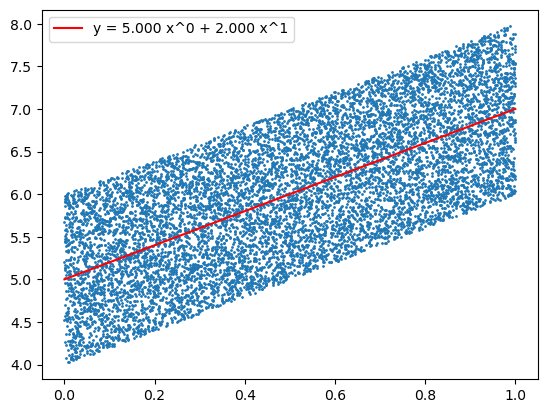

In [3]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(456513516)))
n = 10_000
params = [
    5, # intercept 
    2, # slope
]
    
x, y, yn, params = generate_linear_1d(n, params)

plot_data(x, yn)
plot_curve(x, y, params)
plt.legend()
plt.show()

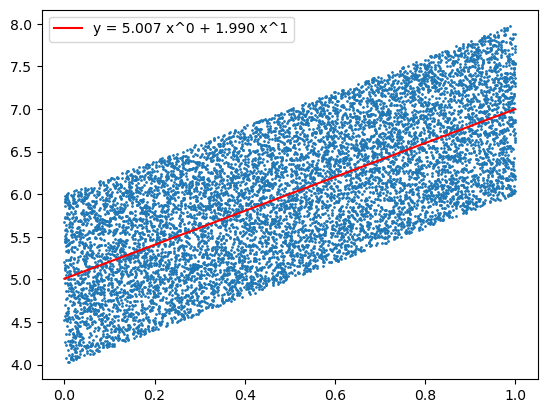

In [4]:
# let's check how a linear model performs on this data set
params_h = fit(x, yn, deg = 1)
yh = pred(x, params_h)
plot_data(x, yn)
plot_curve(x, yh, params_h)
plt.legend()
plt.show()

In [5]:
rmse(yh, y),rmse(yh, yn)

(0.0036456001821257144, 0.5795268977688411)

# fit a second degree model
let's look at degree 2 polynomials

In [6]:
params_h = fit(x, yn, deg = 2)
yh = pred(x, params_h)

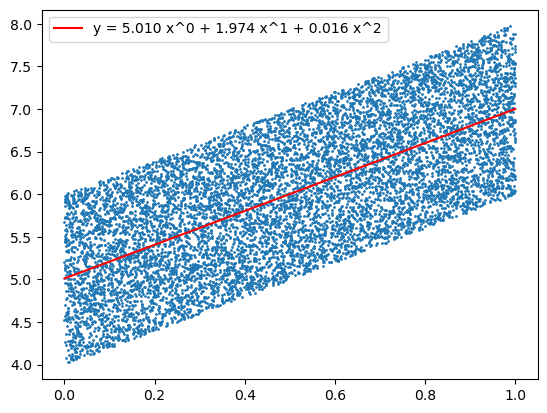

In [7]:
plot_data(x, yn)
plot_curve(x, yh, params_h)
plt.legend()
plt.show()

In [8]:
rmse(yh, y), rmse(yh, yn)

(0.003833011991321623, 0.5795256885223805)

# sample x and fit model on the sample

In [9]:
s = 1000 # sample size
sam = np.unique(np.random.randint(low = 0, high=n, size=s, dtype=int))
xs = x[sam]
yns = yn[sam]

In [10]:
params_h = fit(xs, yns, deg = 2)
yh = pred(x, params_h)

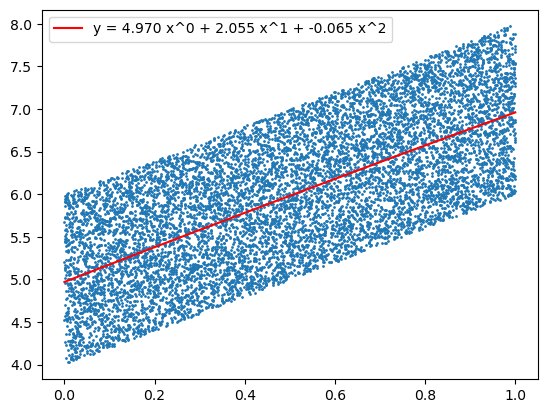

In [11]:
plot_data(x, yn)
plot_curve(x, yh, params_h)
plt.legend()
plt.show()

In [12]:
rmse(yh, y), rmse(yh, yn)

(0.025381856060485063, 0.5801878951157862)

ok, this is a point estimate using all of the data at once, we don't have a way of testing statistical significance

# do it several times and average

In [13]:
s = 100 # sample size
n_iter = 2000

rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(456513516)))
all_params = np.zeros([1,3])
for i in range(n_iter):
    sam = np.unique(rs.randint(low = 0, high=n, size=s, dtype=int))
    xs = x[sam]
    yns = yn[sam]
    params_h = fit(xs, yns, deg = 2)
    yh = pred(x, params_h)
    all_params = np.append(all_params, params_h, axis=0)
all_params = all_params[1:, :] # remove the first row that was randomly generated

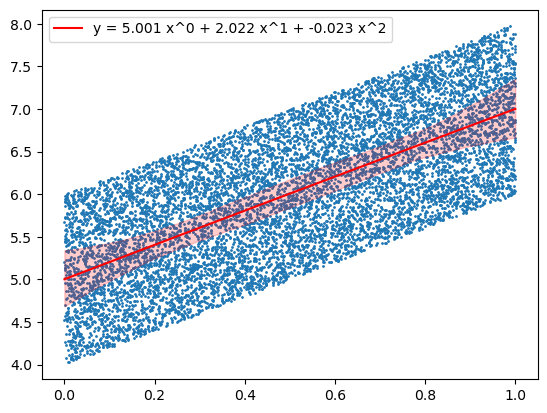

In [14]:
params_mean = np.mean(all_params, axis = 0).reshape([1,-1])
yh = pred(x, params_mean)
[yhl,yhu] = pred_conf(x, all_params, alpha = .05)
    
plot_pred_conf(x, yn, yh, params_mean, yhl, yhu)

In [15]:
rmse(yh, y), rmse(yh, yn)

(0.004905808465542589, 0.5795428110928361)

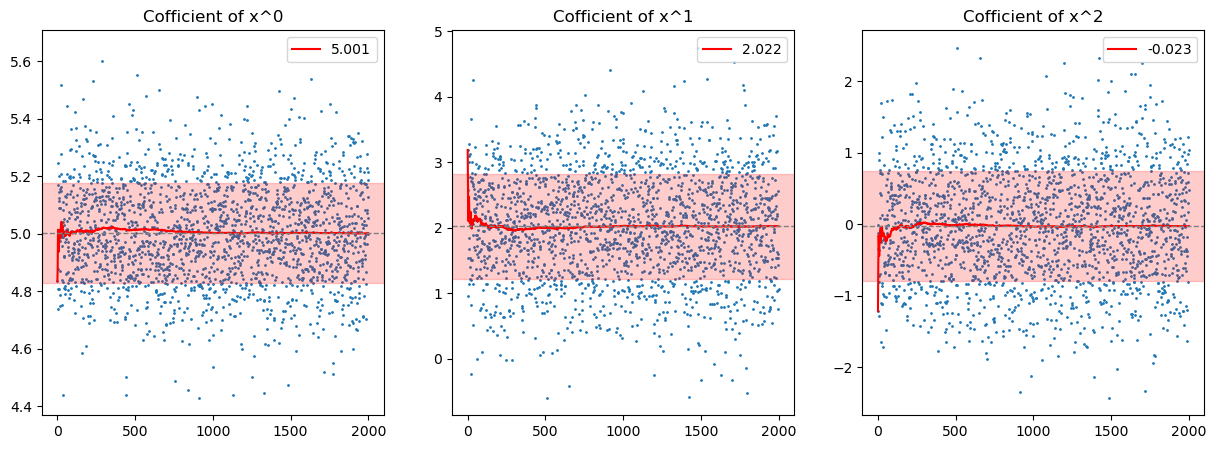

In [16]:
plot_all_params(all_params)

In [17]:
params_u = np.percentile(a = all_params, q = 97.5, axis = 0)
params_l = np.percentile(a = all_params, q = 2.5, axis = 0)
params_m = np.percentile(a = all_params, q = 50, axis = 0)

In [18]:
params_u, params_l, params_m, params_mean

(array([5.34029158, 3.55267257, 1.51050047]),
 array([ 4.68240348,  0.45350055, -1.48263074]),
 array([ 4.99510577,  2.02659348, -0.04044468]),
 array([[ 5.00129272,  2.02203398, -0.02319132]]))

In [19]:
# non-stat-sig coefficients become zero
params_h = params_mean * (params_u * params_l > 0)
params_h

array([[ 5.00129272,  2.02203398, -0.        ]])

In [20]:
yh = pred(x, params_h)

In [21]:
rmse(yh, y), rmse(yh, yn)

(0.013856224435676055, 0.579685996829003)

# Let's put all of this together

In [22]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(456513516)))
n = 10_000
params = [
    5, # intercept 
    2, # slope
]
s = n //2 # sample size
n_iter = 2000

x, y, yn, params = generate_linear_1d(n, params)

[
    yh, 
    yhl,
    yhu, 
    params_u,
    params_l,
    params_h, 
    params_mean,
    all_params
] = sample_pred_sig(
    x,
    yn,
    deg = 2,
    s = s,
    n_iter = n_iter, 
    alpha = .05
)

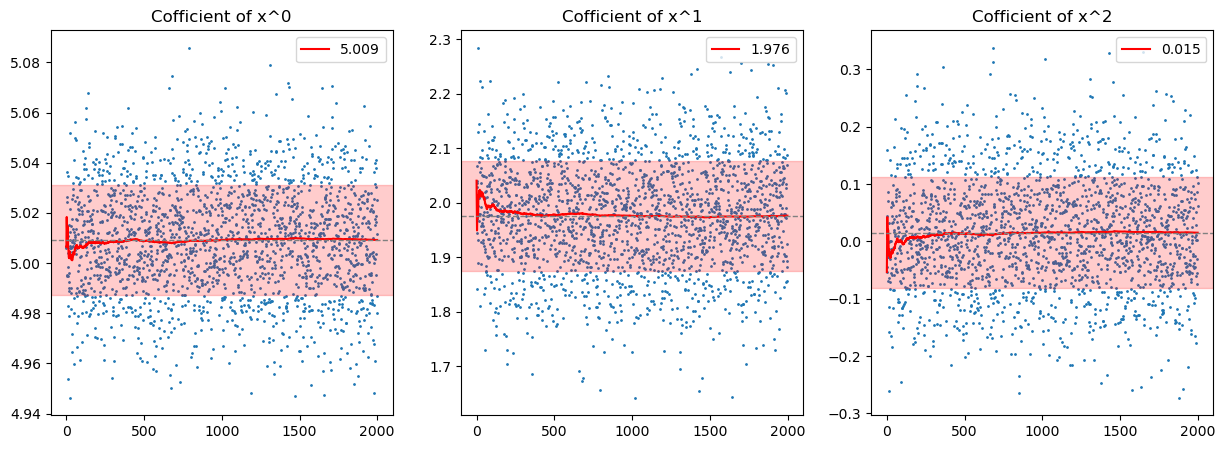

In [23]:
plot_all_params(all_params)

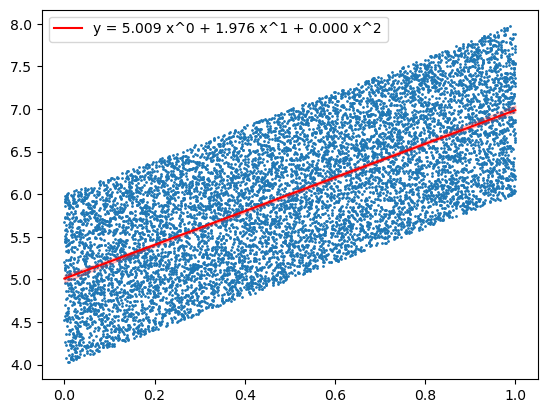

In [24]:
plot_pred_conf(x, yn, yh, params_h, yhl, yhu)

looks pretty promising! We can start meausuring how well it is performing.

In [25]:
rmse(yh, y), rmse(yh, yn)

(0.0073082355016158285, 0.5795615408906665)

# what if it was 3rd degree?

It doesn't work anymore!

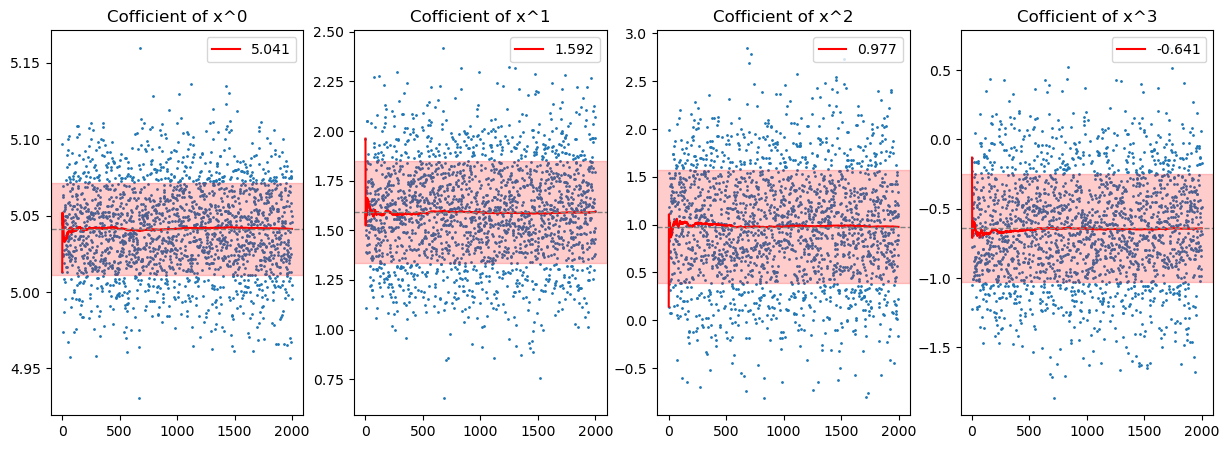

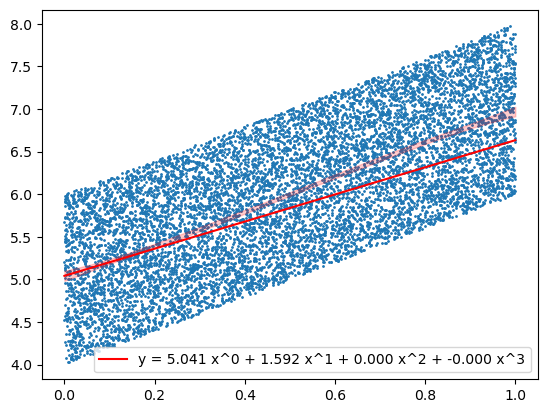

rmse:  0.20103506455874787 0.6134862880090465


In [26]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(456513516)))
n = 10_000
params = [
    5, # intercept 
    2, # slope
]
s = n//2 # sample size
n_iter = 2000

x, y, yn, params = generate_linear_1d(n, params)

[
    yh, 
    yhl,
    yhu, 
    params_u,
    params_l,
    params_h, 
    params_mean,
    all_params
] = sample_pred_sig(
    x,
    yn,
    deg = 3,
    s = s,
    n_iter = n_iter, 
    alpha = .05
)
plot_all_params(all_params)
plot_pred_conf(x, yn, yh, params_h, yhl, yhu)
print('rmse: ', rmse(yh, y), rmse(yh, yn))

This is interesting, but needs manual work!

Also, the mean is not anymore relevant, because the confidence intervals are not aroung it.

probably needs some iteration to make it better

# what if we had only a few samples?

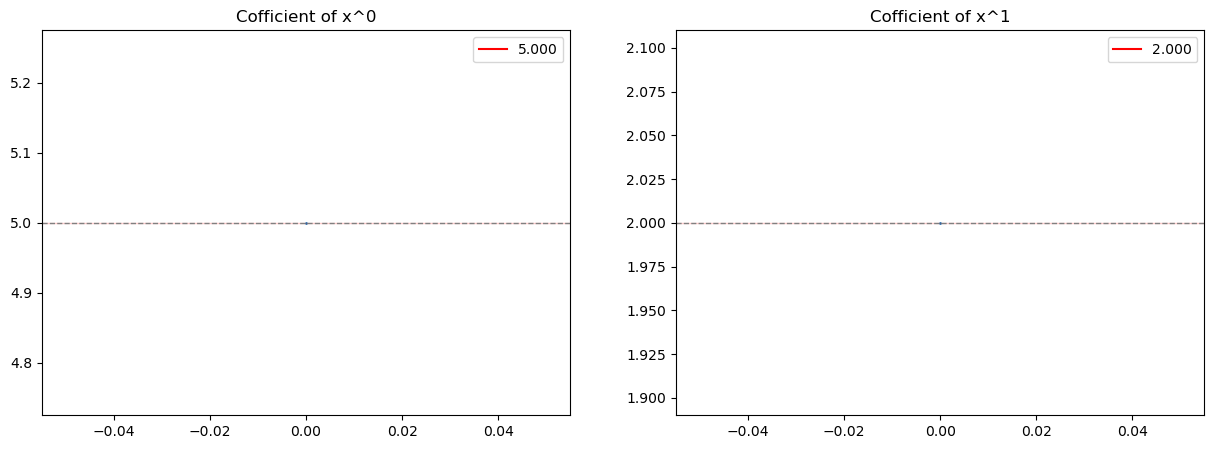

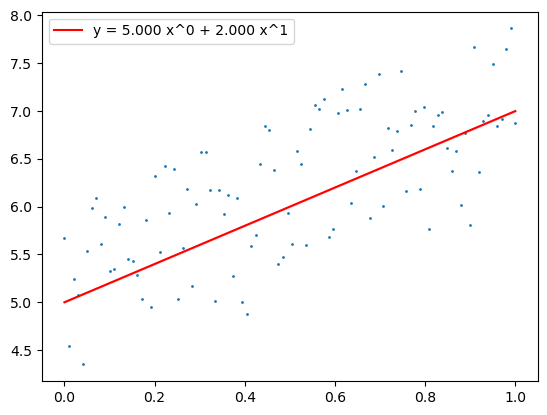

rmse:  1.843906315815031e-15 0.5770090400840235


In [33]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(456513516)))
n = 100
params = [
    5, # intercept 
    2, # slope
]
s = 100 # this means just a liear fit
n_iter = 1

x, y, yn, params = generate_linear_1d(n, params)

[
    yh, 
    yhl,
    yhu, 
    params_u,
    params_l,
    params_h, 
    params_mean,
    all_params
] = sample_pred_sig(
    x,
    yn,
    deg = 1,
    s = s,
    n_iter = n_iter, 
    alpha = .05
)
plot_all_params(all_params)
plot_pred_conf(x, yn, yh, params_h, yhl, yhu)
print('rmse: ', rmse(yh, y), rmse(yh, yn))

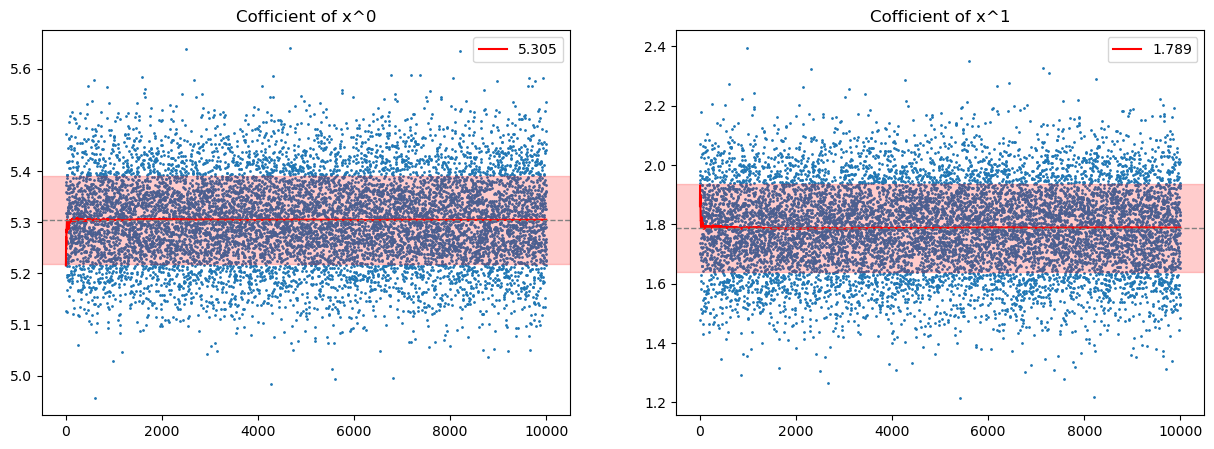

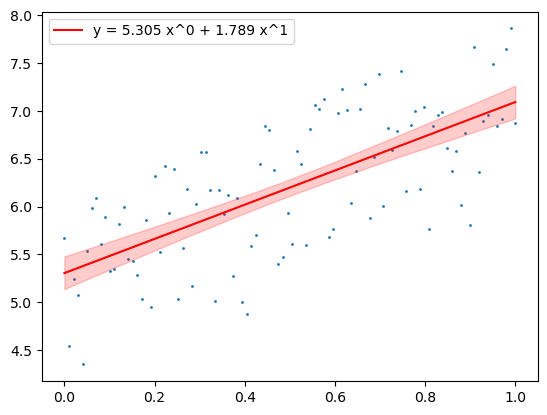

rmse:  0.20869356786474227 0.5379120275796213


In [34]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(456513516)))
n = 100
params = [
    5, # intercept 
    2, # slope
]
s = int(.9 * n) # sample size
n_iter = 10000

x, y, yn, params = generate_linear_1d(n, params)

[
    yh, 
    yhl,
    yhu, 
    params_u,
    params_l,
    params_h, 
    params_mean,
    all_params
] = sample_pred_sig(
    x,
    yn,
    deg = 1,
    s = s,
    n_iter = n_iter, 
    alpha = .05
)
plot_all_params(all_params)
plot_pred_conf(x, yn, yh, params_h, yhl, yhu)
print('rmse: ', rmse(yh, y), rmse(yh, yn))

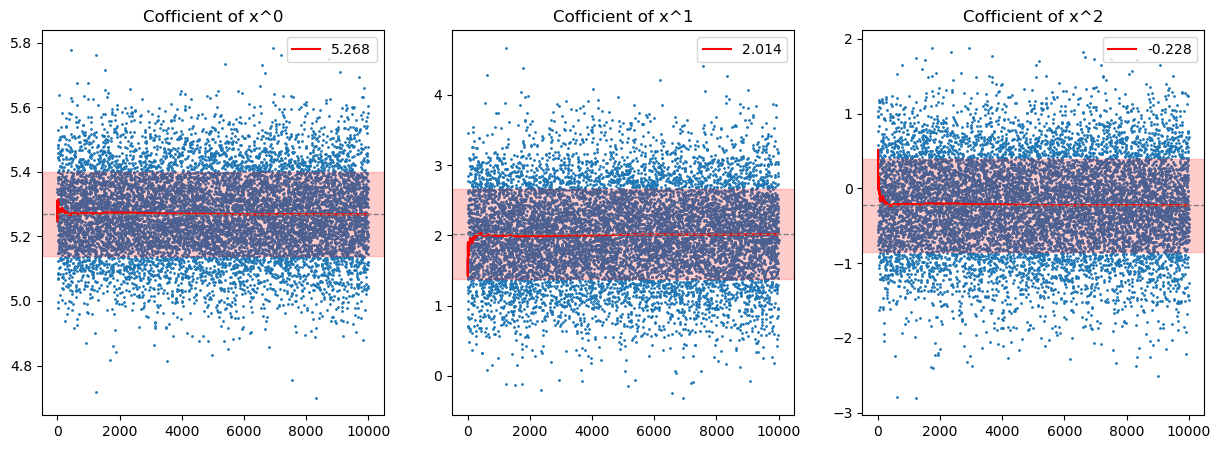

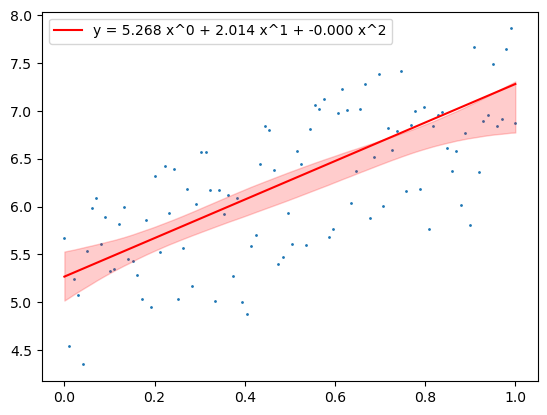

rmse:  0.27544234903678266 0.5472398686642059


In [35]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(456513516)))
n = 100
params = [
    5, # intercept 
    2, # slope
]
s = int(.9 * n) # sample size
n_iter = 10000

x, y, yn, params = generate_linear_1d(n, params)

[
    yh, 
    yhl,
    yhu, 
    params_u,
    params_l,
    params_h, 
    params_mean,
    all_params
] = sample_pred_sig(
    x,
    yn,
    deg = 2,
    s = s,
    n_iter = n_iter, 
    alpha = .05
)
plot_all_params(all_params)
plot_pred_conf(x, yn, yh, params_h, yhl, yhu)
print('rmse: ', rmse(yh, y), rmse(yh, yn))

This means we can decide what coefficients to ignore and then make the model iteratively simpler